# K-means Clustering 

In this exercise, you will implement the K-means algorithm and use it for image compression. 

* You will start with a sample dataset that will help you gain an intuition of how the K-means algorithm works. 
* After that, you will use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.




# Outline
- [ 1 - Implementing K-means](#1)
  - [ 1.1 Finding closest centroids](#1.1)
    - [ Exercise 1](#ex01)
  - [ 1.2 Computing centroid means](#1.2)
    - [ Exercise 2](#ex02)
- [ 2 - K-means on a sample dataset ](#2)
- [ 3 - Random initialization](#3)
- [ 4 - Image compression with K-means](#4)
  - [ 4.1 Dataset](#4.1)
  - [ 4.2 K-Means on image pixels](#4.2)
  - [ 4.3 Compress the image](#4.3)


First, run the cell below to import the packages needed in this assignment:

- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- `utils.py` contains helper functions for this assignment. You do not need to modify code in this file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

<a name="1"></a>
## 1 - Implementing K-means

The K-means algorithm is a method to automatically cluster similar
data points together. 

* You are given a training set $\{x^{(1)}, ..., x^{(m)}\}$, and you want
to group the data into a few cohesive “clusters”. 


* K-means is an iterative procedure that
     * Starts by guessing the initial centroids, and then 
     * Refines this guess by 
         * Repeatedly assigning examples to their closest centroids, and then 
         * Recomputing the centroids based on the assignments.
         

* In pseudocode, the K-means algorithm is as follows:

    ``` python
    # Initialize centroids
    # K is the number of clusters
    centroids = kMeans_init_centroids(X, K)
    
    for iter in range(iterations):
        # Cluster assignment step: 
        # Assign each data point to the closest centroid. 
        # idx[i] corresponds to the index of the centroid 
        # assigned to example i
        idx = find_closest_centroids(X, centroids)

        # Move centroid step: 
        # Compute means based on centroid assignments
        centroids = compute_centroids(X, idx, K)
    ```


* The inner-loop of the algorithm repeatedly carries out two steps: 
    1. Assigning each training example $x^{(i)}$ to its closest centroid, and
    2. Recomputing the mean of each centroid using the points assigned to it. 
    
    
* The $K$-means algorithm will always converge to some final set of means for the centroids. 

* However, the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

You will implement the two phases of the K-means algorithm separately
in the next sections. 
* You will start by completing `find_closest_centroid` and then proceed to complete `compute_centroids`.

<a name="1.1"></a>
### 1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the
algorithm assigns every training example $x^{(i)}$ to its closest
centroid, given the current positions of centroids. 

<a name="ex01"></a>
### Exercise 1

Your task is to complete the code in `find_closest_centroids`. 
* This function takes the data matrix `X` and the locations of all
centroids inside `centroids` 
* It should output a one-dimensional array `idx` (which has the same number of elements as `X`) that holds the index  of the closest centroid (a value in $\{0,...,K-1\}$, where $K$ is total number of centroids) to every training example . *(Note: The index range 0 to K-1 varies slightly from what is shown in the lectures (i.e. 1 to K) because Python list indices start at 0 instead of 1)*
* Specifically, for every example $x^{(i)}$ we set
$$c^{(i)} := j \quad \mathrm{that \; minimizes} \quad ||x^{(i)} - \mu_j||^2,$$
where 
 * $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ (corresponds to `idx[i]` in the starter code), and 
 * $\mu_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code)

In [2]:
# GRADED FUNCTION: find_closest_centroids

def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): (K, n) centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """

    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly
    idx = np.zeros(X.shape[0], dtype=int)

    ### START CODE HERE ###
    for i in range(X.shape[0]):
        curr_idx = 0
        curr_dist = np.linalg.norm(X[i] - centroids[0])
        for j in range(1, K):
            temp_dist = np.linalg.norm(X[i] - centroids[j])
            if temp_dist < curr_dist:
                curr_dist = temp_dist
                curr_idx = j
        idx[i] = curr_idx
    
     ### END CODE HERE ###
    
    return idx

Now let's check your implementation using an example dataset

In [3]:
# Load an example dataset that we will be using
X = load_data()

The code below prints the first five elements in the variable `X` and the dimensions of the variable

In [4]:
print("First five elements of X are:\n", X[:5]) 
print('The shape of X is:', X.shape)

First five elements of X are:
 [[1.84207953 4.6075716 ]
 [5.65858312 4.79996405]
 [6.35257892 3.2908545 ]
 [2.90401653 4.61220411]
 [3.23197916 4.93989405]]
The shape of X is: (300, 2)


In [5]:
# Select an initial set of centroids (3 Centroids)
initial_centroids = np.array([[3,3], [6,2], [8,5]])

# Find closest centroids using initial_centroids
idx = find_closest_centroids(X, initial_centroids)

# Print closest centroids for the first three elements
print("First three elements in idx are:", idx[:3])

# UNIT TEST
from public_tests import *

find_closest_centroids_test(find_closest_centroids)

First three elements in idx are: [0 2 1]
All tests passed!


**Expected Output**:
<table>
  <tr>
    <td> <b>First three elements in idx are<b></td>
    <td> [0 2 1] </td> 
  </tr>
</table>

<a name="1.2"></a>
### 1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the
algorithm recomputes, for each centroid, the mean of the points that
were assigned to it.


<a name="ex02"></a>
### Exercise 2

Please complete the `compute_centroids` below to recompute the value for each centroid

* Specifically, for every centroid $\mu_k$ we set
$$\mu_k = \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}$$ 

    where 
    * $C_k$ is the set of examples that are assigned to centroid $k$
    * $|C_k|$ is the number of examples in the set $C_k$


* Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k=2$,
then you should update $\mu_2 = \frac{1}{2}(x^{(3)}+x^{(5)})$.

In [8]:
# GRADED FUNCTION: compute_centpods

def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # Useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly
    centroids = np.zeros((K, n))
    
    ### START CODE HERE ###                      
    centroids_counts = np.zeros(K)
    for i in range(m):
        centroids_counts[idx[i]] += 1
        centroids[idx[i]] += X[i]

    centroids /= centroids_counts[:,None]

    ### END CODE HERE ## 
    
    return centroids

Now check your implementation by running the cell below

In [9]:
K = 3
centroids = compute_centroids(X, idx, K)

print(f'The centroids are:\n{centroids}')

# UNIT TEST
compute_centroids_test(compute_centroids)

The centroids are:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]
All tests passed!


**Expected Output**:

2.42830111 3.15792418

5.81350331 2.63365645

7.11938687 3.6166844 

<a name="2"></a>
## 2 - K-means on a sample dataset 

After you have completed the two functions (`find_closest_centroids`
and `compute_centroids`) above, the next step is to run the
K-means algorithm on a toy 2D dataset to help you understand how
K-means works. 
* You are encouraged to take a look at the function (`run_kMeans`) below to understand how it works. 
* Notice that the code calls the two functions you implemented in a loop.

When you run the code below, it will produce a
visualization that steps through the progress of the algorithm at
each iteration. 
* At the end, your figure should look like the one displayed in Figure 1.

<img src="images/figure 1.png" width="500" height="500">


**Note**: You do not need to implement anything for this part. Simply run the code provided below

In [10]:
# You do not need to implement anything for this part

def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    
    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show() 
    return centroids, idx

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


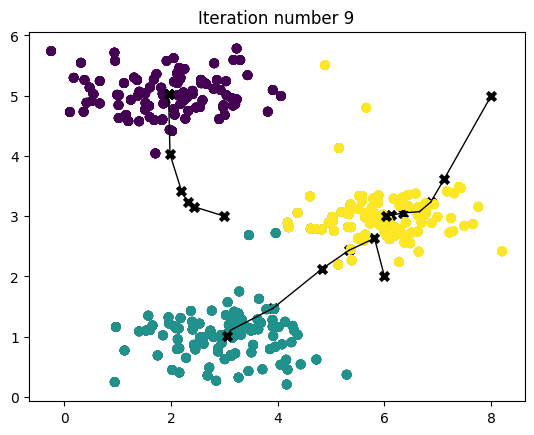

In [11]:
# Load an example dataset
X = load_data()

# Set initial centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]])
K = 3

# Number of iterations
max_iters = 10

centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

<a name="3"></a>
## 3 - Random initialization

The initial assignments of centroids for the example dataset was designed so that you will see the same figure as in Figure 1. In practice, a good strategy for initializing the centroids is to select random examples from the
training set.

In this part of the exercise, you should understand how the function `kMeans_init_centroids` is implemented.
* The code first randomly shuffles the indices of the examples (using `np.random.permutation()`). 
* Then, it selects the first $K$ examples based on the random permutation of the indices. 
    * This allows the examples to be selected at random without the risk of selecting the same example twice.

**Note**: You do not need to implement anything for this part of the exercise.

In [12]:
# You do not need to modify this part

def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be 
    used in K-Means on the dataset X
    
    Args:
        X (ndarray): Data points 
        K (int):     number of centroids/clusters
    
    Returns:
        centroids (ndarray): Initialized centroids
    """
    
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])
    
    # Take the first K examples as centroids
    centroids = X[randidx[:K]]
    
    return centroids

<a name="4"></a>
## 4 - Image compression with K-means

In this exercise, you will apply K-means to image compression. 

* In a straightforward 24-bit color representation of an image$^{2}$, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding.
* Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of
colors to 16 colors.
* By making this reduction, it is possible to represent (compress) the photo in an efficient way. 
* Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this part, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image.
* Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3- dimensional RGB space. 
* Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

<img src="images/figure 2.png" width="500" height="500">

$^{2}$<sub>The provided photo used in this exercise belongs to Frank Wouters and is used with his permission.</sub>

<a name="4.1"></a>
### 4.1 Dataset

**Load image**

First, you will use `matplotlib` to read in the original image, as shown below.

In [13]:
# Load an image of a bird
original_img = plt.imread('bird_small.png')

**Visualize image**

You can visualize the image that was just loaded using the code below.

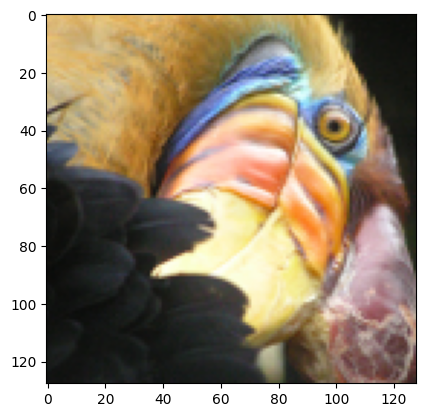

In [14]:
# Visualizing the image
plt.imshow(original_img)

**Check the dimension of the variable**

As always, you will print out the shape of your variable to get more familiar with the data.

In [15]:
print("Shape of original_img is:", original_img.shape)

Shape of original_img is: (128, 128, 3)


As you can see, this creates a three-dimensional matrix `original_img` where 
* the first two indices identify a pixel position, and
* the third index represents red, green, or blue. 

For example, `original_img[50, 33, 2]` gives the blue intensity of the pixel at row 50 and column 33.

#### Processing data

To call the `run_kMeans`, you need to first transform the matrix `original_img` into a two-dimensional matrix.

* The code below reshapes the matrix `original_img` to create an $m \times 3$ matrix of pixel colors (where
$m=16384 = 128\times128$)

In [16]:
# Divide by 255 so that all values are in the range 0 - 1
original_img = original_img / 255

# Reshape the image into an m x 3 matrix where m = number of pixels
# (in this case m = 128 x 128 = 16384)
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X_img that we will use K-Means on.

X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))

<a name="4.2"></a>
### 4.2 K-Means on image pixels

Now, run the cell below to run K-Means on the pre-processed image.

In [17]:
# Run your K-Means algorithm on this data
# You should try different values of K and max_iters here
K = 16                       
max_iters = 10               

# Using the function you have implemented above. 
initial_centroids = kMeans_init_centroids(X_img, K) 

# Run K-Means - this takes a couple of minutes
centroids, idx = run_kMeans(X_img, initial_centroids, max_iters) 

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


In [18]:
print("Shape of idx:", idx.shape)
print("Closest centroid for the first five elements:", idx[:5])

Shape of idx: (16384,)
Closest centroid for the first five elements: [4 4 4 4 4]


<a name="4.3"></a>
### 4.3 Compress the image


After finding the top $K=16$ colors to represent the image, you can now
assign each pixel position to its closest centroid using the
`find_closest_centroids` function. 
* This allows you to represent the original image using the centroid assignments of each pixel. 
* Notice that you have significantly reduced the number of bits that are required to describe the image. 
    * The original image required 24 bits (i.e. 8 bits x 3 channels in RGB encoding) for each one of the $128\times128$ pixel locations, resulting in total size of $128 \times 128 \times 24 = 393,216$ bits. 
    * The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. 
    * The final number of bits used is therefore $16 \times 24 + 128 \times 128 \times 4 = 65,920$ bits, which corresponds to compressing the original image by about a factor of 6.

In [19]:
# Represent image in terms of indices
X_recovered = centroids[idx, :] 

# Reshape recovered image into proper dimensions
X_recovered = np.reshape(X_recovered, original_img.shape) 

Finally, you can view the effects of the compression by reconstructing
the image based only on the centroid assignments. 
* Specifically, you can replace each pixel location with the value of the centroid assigned to
it. 
* Figure 3 shows the reconstruction we obtained. Even though the resulting image retains most of the characteristics of the original, we also see some compression artifacts.

<img src="images/figure 3.png" width="700" height="700">


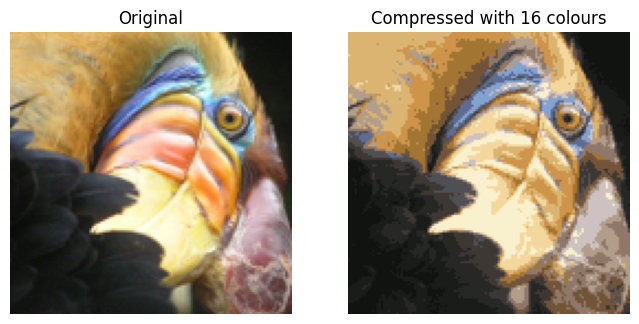

In [20]:
# Display original image
fig, ax = plt.subplots(1,2, figsize=(8,8))
plt.axis('off')

ax[0].imshow(original_img*255)
ax[0].set_title('Original')
ax[0].set_axis_off()


# Display compressed image
ax[1].imshow(X_recovered*255)
ax[1].set_title('Compressed with %d colours'%K)
ax[1].set_axis_off()